In [90]:
import pandas as pd
import numpy as np
import praw
import datetime
import time
from matplotlib import pyplot as plt
from collections import defaultdict
import copy

In [91]:
# hide my api access stuff
auth = open("secret", "r").read().split('|')
CLIENT_ID = auth[0]
SECRET_KEY = auth[1]

In [92]:
# make a PRAW reddit instance
reddit = praw.Reddit (
    client_id=CLIENT_ID,
    client_secret=SECRET_KEY,
    user_agent="uhhh idk",
)

# USER_ONE = 'jmct' #professor
# USER_TWO = 'ariqbailey'
USER_ONE = 'ariqbailey'
USER_TWO = 'jmct'

# get users account creation dates
# user_two_creation = reddit.redditor(USER_TWO).created_utc

In [93]:
# get users comments
LIMIT = None
user_one_comments = reddit.redditor(USER_ONE).comments.new(limit=LIMIT)
one_comment_df = pd.DataFrame(columns=['body', 'body_length', 'subreddit', 'created_utc'])

i = 0
for comment in user_one_comments:
    one_comment_df.loc[i] = [comment.body, len(comment.body), comment.subreddit, comment.created_utc]
    i += 1

In [94]:
one_comment_df.head()

,body,body_length,subreddit,created_utc
0,This is hilarious! Loved the quip about cuttin...,81,OCPoetry,1.619289e+09
1,This is very nicely done. Good job!,35,UMD,1.619274e+09
2,Anyone know if this feature has rolled out to ...,77,kindle,1.618535e+09
3,Ah thank you,12,UMD,1.618440e+09
4,What’s mmWave for the uninitiated? Is that the...,86,UMD,1.618440e+09


In [95]:
# add date column
one_comment_df['date'] = [None] * len(one_comment_df)

# add standard date
for i,r in one_comment_df.iterrows():
    one_comment_df.at[i, 'date'] = datetime.datetime.fromtimestamp(r['created_utc'])

# Find average comment length for user one's subreddits, and create a weighting system based off this

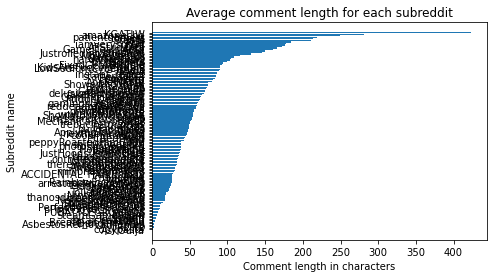

In [96]:
subreddits = {}
for i, r in one_comment_df.iterrows():
    if(not str(r['subreddit']) in subreddits):
        subreddits[str(r['subreddit'])] = [0, 0]

    subreddits[str(r['subreddit'])] = [subreddits[str(r['subreddit'])][0] + r['body_length'], subreddits[str(r['subreddit'])][1] + 1]

sub_avgs = {}
sub_avgs = defaultdict(lambda: 0, sub_avgs)

for k in subreddits:
    sub_avgs[k] = int(subreddits[k][0] / subreddits[k][1])

sub_names_sorted = []
sub_avgs_sorted = []
for i in sorted(sub_avgs.keys(), key=lambda x: sub_avgs[x]):
    sub_names_sorted.append(i)
    sub_avgs_sorted.append(sub_avgs[i])

plt.barh(sub_names_sorted, sub_avgs_sorted)
plt.title('Average comment length for each subreddit')
plt.xlabel('Comment length in characters')
plt.ylabel('Subreddit name')
plt.show()

Looking at this graph, we should therefore be able to create a weight with a linear relationship to comment_body_length

In [97]:
# generate weights proportional to average comment length for each subreddit
one_avg_comment_len = one_comment_df['body_length'].mean()

one_comment_df['length_weight'] = [None] * len(one_comment_df)

for i,r in one_comment_df.iterrows():
    one_comment_df.at[i, 'length_weight'] = r['body_length'] / one_avg_comment_len

one_comment_df.head()

,body,body_length,subreddit,created_utc,date,length_weight
0,This is hilarious! Loved the quip about cuttin...,81,OCPoetry,1.619289e+09,2021-04-24 14:29:26,1.12162
1,This is very nicely done. Good job!,35,UMD,1.619274e+09,2021-04-24 10:17:05,0.48465
2,Anyone know if this feature has rolled out to ...,77,kindle,1.618535e+09,2021-04-15 20:59:52,1.06623
3,Ah thank you,12,UMD,1.618440e+09,2021-04-14 18:45:37,0.166166
4,What’s mmWave for the uninitiated? Is that the...,86,UMD,1.618440e+09,2021-04-14 18:34:21,1.19086


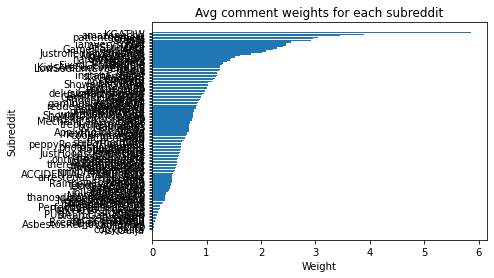

In [98]:
# print avg length_weight for each subreddit

subs_comment_weights = {}
subs_comment_weights = defaultdict(lambda: 0, subs_comment_weights)
for k in subreddits:
    sub_df = one_comment_df[one_comment_df.subreddit == k]
    subs_comment_weights[k] = sub_df['length_weight'].mean()

# {l: v for k,v in sorted(subs_comment_weights.items(), key=lambda item: item[1])}
sorted_comment_weights = sorted(subs_comment_weights.items(), key=lambda x: x[1])
    
x = []
y = []
for k, v in sorted_comment_weights:
    x.append(k)
    y.append(v)

plt.barh(x, y)
plt.title('Avg comment weights for each subreddit')
plt.xlabel('Weight')
plt.ylabel('Subreddit')
plt.show()

By comparing the shape of this with the previous graph, we can be happy that our weights properly reflect comment length.

# Create a weighting system based off the age of user one's comments
## Let's assume that a redditor's interest in a given topic declines proportinally to the time that has passed since they made the comment. After three years, let's say that their interest in a given topic has decayed by half. In other words, let's create a half life of interest.

In [99]:
# weight comments by age
# Assume interest decays by half in a period of 3 years
INTEREST_HALF_LIFE = 94670778 # 3 years

# create new column
one_comment_df['age_weight'] = [None] * len(one_comment_df)

# get current time
current_time = time.time()

for i, r in one_comment_df.iterrows():
    time_diff = current_time - r['created_utc']

    if time_diff > INTEREST_HALF_LIFE:
        one_comment_df.at[i, 'age_weight'] = .5
    else:
        one_comment_df.at[i, 'age_weight'] = 1 - (time_diff / (INTEREST_HALF_LIFE * 2)) 

In [100]:
one_comment_df.tail()

,body,body_length,subreddit,created_utc,date,length_weight,age_weight
442,Reading -2 39\nWriting -2 38\nMath -6 36.5,40,Sat,1.510955e+09,2017-11-17 16:48:40,0.553886,0.5
443,1500,4,Sat,1.510955e+09,2017-11-17 16:35:34,0.0553886,0.5
444,same,4,Sat,1.510952e+09,2017-11-17 15:50:04,0.0553886,0.5
445,"I did make a fork, and I may post my changes o...",1395,amazonecho,1.480042e+09,2016-11-24 21:46:16,19.3168,0.5
446,This is awesome: thank you so much for this! \...,152,amazonecho,1.479922e+09,2016-11-23 12:22:28,2.10477,0.5


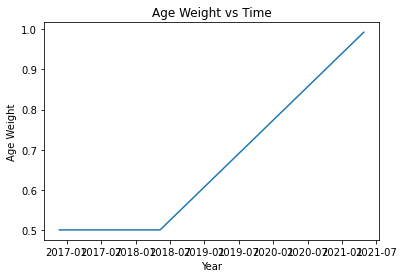

In [101]:
plt.plot(one_comment_df['date'], one_comment_df['age_weight'])
plt.title("Age Weight vs Time")
plt.xlabel("Year")
plt.ylabel("Age Weight")
plt.show()

# Repeat all of this for USER 2

In [102]:
# get users comments
LIMIT = None
user_two_comments = reddit.redditor(USER_TWO).comments.new(limit=LIMIT)
two_comment_df = pd.DataFrame(columns=['body', 'body_length', 'subreddit', 'created_utc'])

i = 0
for comment in user_two_comments:
    two_comment_df.loc[i] = [comment.body, len(comment.body), comment.subreddit, comment.created_utc]
    i += 1

# comment length weight
two_avg_comment_len = two_comment_df['body_length'].mean()

two_comment_df['length_weight'] = [None] * len(two_comment_df)

for i,r in two_comment_df.iterrows():
    two_comment_df.at[i, 'length_weight'] = r['body_length'] / two_avg_comment_len

# weight comments by age
# create new column
two_comment_df['age_weight'] = [None] * len(two_comment_df)

for i, r in two_comment_df.iterrows():
    time_diff = current_time - r['created_utc']

    if time_diff > INTEREST_HALF_LIFE:
        two_comment_df.at[i, 'age_weight'] = .5
    else:
        two_comment_df.at[i, 'age_weight'] = 1 - (time_diff / (INTEREST_HALF_LIFE * 2)) 

two_comment_df.head()

,body,body_length,subreddit,created_utc,length_weight,age_weight
0,Depends what you mean by Professor.\n\nTechnic...,523,UMD,1.616204e+09,1.31217,0.976319
1,"I find it very demoralizing and, worse, diffic...",186,UMD,1.614618e+09,0.46666,0.967942
2,I actually thought the point was more interest...,368,musictheory,1.612901e+09,0.923285,0.958869
3,"It all seems relatively benign, which just rai...",72,law,1.611119e+09,0.180643,0.94946
4,I’ve always found mutt to be clunky with multi...,199,linux,1.610816e+09,0.499276,0.947857


In [103]:
print(one_avg_comment_len, two_avg_comment_len)

72.21700223713647 398.5768194070081


# Now let's analyze submission data for user one

In [104]:
# get users posts
user_one_posts = reddit.redditor(USER_ONE).submissions.new(limit=LIMIT)
one_post_df = pd.DataFrame(columns=['title', 'body', 'body_length', 'subreddit', 'created_utc'])

i = 0
for post in user_one_posts:
    one_post_df.at[i] = [post.title, post.selftext, len(post.selftext), post.subreddit, post.created_utc]
    i += 1

In [105]:
one_post_df.head()

,title,body,body_length,subreddit,created_utc
0,Sublet in Logan Circle area,I'm looking to sublet a place in the Logan Cir...,178,DCforRent,1.61799e+09
1,[Opinion] Dana White should support (and maybe...,This post is not a personal endorsement nor a ...,1696,ufc,1.61515e+09
2,First time making smash onion burgers on my ne...,,0,burgers,1.61299e+09
3,Got this knife killing a thug in the Day in th...,,0,cyberpunkgame,1.61e+09
4,Got this knife killing a thug in the Day in th...,,0,cyberpunkgame,1.61e+09


# Let's find the average post lengths in user one's subreddits

In [106]:
subreddits = {}
subreddits = defaultdict(lambda: [0, 0], subreddits)

# get average post length for each subreddit
for i, r in one_post_df.iterrows():
    sub = str(r['subreddit'])
    subreddits[sub] = [subreddits[sub][0] + r['body_length'], subreddits[sub][1] + 1]

for sub in subreddits:
    subreddits[sub] = subreddits[sub][0] / subreddits[sub][1]

subreddits_sorted_one = sorted(subreddits.items(), key=lambda x: x[1])
print(subreddits_sorted_one)

[('burgers', 0.0), ('cyberpunkgame', 0.0), ('JustHoodsLemonBars', 0.0), ('AskReddit', 0.0), ('im14andthisisdeep', 0.0), ('FellowKids', 0.0), ('smashbros', 0.0), ('torrents', 9.0), ('FixedGearBicycle', 9.0), ('DCforRent', 178.0), ('APStudents', 241.0), ('copypasta', 247.0), ('ShouldIbuythisgame', 266.0), ('Sat', 347.0), ('buildapc', 629.0), ('Dell', 656.0), ('GameDealsMeta', 695.0), ('VPNTorrents', 887.0), ('bikewrench', 954.0), ('AppleWatch', 961.0), ('VPN', 1096.0), ('ufc', 1696.0)]


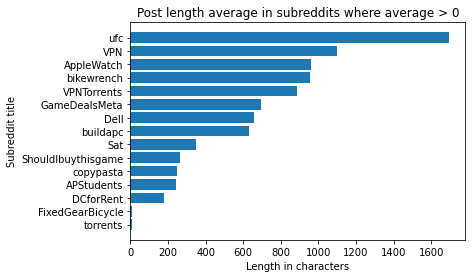

In [107]:
sub_keys = []
sub_vals = []
for k, v in subreddits_sorted_one:
    if v != 0:
        sub_keys.append(k)
        sub_vals.append(v)

plt.barh(sub_keys, sub_vals)
plt.title("Post length average in subreddits where average > 0")
plt.xlabel("Length in characters")
plt.ylabel("Subreddit title")
plt.show()

In [108]:
# find overall post length average for user one
one_post_average = one_post_df['body_length'].mean()
print(one_post_average)

395.8333333333333


# Let's create a weighting system based on average post length for subreddits

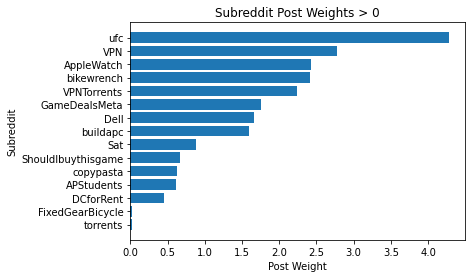

In [109]:
# create weights for post length compared to average for user one
one_post_df['length_weight'] = [None] * len(one_post_df)

for i, r in one_post_df.iterrows():
    r['length_weight'] = r['body_length'] / one_post_average

# graph weights for each subreddit
subreddit_post_weights = {}
subreddit_post_weights = defaultdict(lambda: 0, subreddit_post_weights)
for sub in subreddits.keys():
    curr = one_post_df[one_post_df.subreddit == sub]
    subreddit_post_weights[sub] = curr['length_weight'].mean()

subreddit_post_weights = sorted(subreddit_post_weights.items(), key=lambda x: x[1])

sub_keys = []
sub_vals = []
for k, v in subreddit_post_weights:
    if v != 0:
        sub_keys.append(k)
        sub_vals.append(v)

plt.barh(sub_keys, sub_vals)
plt.title("Subreddit Post Weights > 0")
plt.xlabel("Post Weight")
plt.ylabel("Subreddit")
plt.show()

As we can see the post weights for subreddits accurately reflect the average post lengths of given subreddits.

# Lets consider how interest in submission topics decays over time. Lets do something similar to what we did for the comments.

In [110]:
# weight posts by age
# create new column
one_post_df['age_weight'] = [None] * len(one_post_df)

# get current time
current_time = time.time()

for i, r in one_post_df.iterrows():
    time_diff = current_time - r['created_utc']

    if time_diff > INTEREST_HALF_LIFE:
        one_post_df.at[i, 'age_weight'] = .5
    else:
        one_post_df.at[i, 'age_weight'] = 1 - (time_diff / (INTEREST_HALF_LIFE * 2)) 

one_post_df.tail()

,title,body,body_length,subreddit,created_utc,length_weight,age_weight
19,RAM and SSD preforming way below expectations?,I recently purchased a GTX 980Ti to replace my...,871,buildapc,1.53067e+09,2.20042,0.524574
20,EVGA midweek madness sales help?,"Hi, a friend recently told me about the EVGA m...",387,buildapc,1.5299e+09,0.977684,0.520483
21,Apple watch S2 vs S3 vs S4?,"I currently have the Apple watch sport S0, and...",961,AppleWatch,1.52886e+09,2.42779,0.514992
22,Predicting AP Lang Prompts?,From what I've seen from previous year's promp...,241,APStudents,1.52584e+09,0.608842,0.5
23,Should I cancel my test?,I accidentally forgot to do all five of the gr...,347,Sat,1.52071e+09,0.876632,0.5


In [111]:
# add date column
one_post_df['date'] = [None] * len(one_post_df)

# add standard date
for i,r in one_post_df.iterrows():
    one_post_df.at[i, 'date'] = datetime.datetime.fromtimestamp(r['created_utc'])

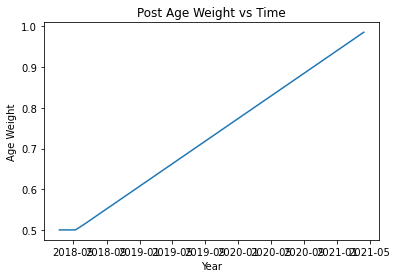

In [112]:
plt.plot(one_post_df['date'], one_post_df['age_weight'])
plt.title("Post Age Weight vs Time")
plt.xlabel("Year")
plt.ylabel("Age Weight")
plt.show()

something something something

# Repeat for user 2

In [113]:
# get users posts
user_two_posts = reddit.redditor(USER_TWO).submissions.new(limit=LIMIT)
two_post_df = pd.DataFrame(columns=['title', 'body', 'body_length', 'subreddit', 'created_utc'])

i = 0
for post in user_two_posts:
    two_post_df.at[i] = [post.title, post.selftext, len(post.selftext), post.subreddit, post.created_utc]
    i += 1

# comment length weight
two_avg_post_len = two_post_df['body_length'].mean()

two_post_df['length_weight'] = [None] * len(two_post_df)

for i,r in two_post_df.iterrows():
    two_post_df.at[i, 'length_weight'] = r['body_length'] / two_avg_post_len

# weight comments by age
# create new column
two_post_df['age_weight'] = [None] * len(two_post_df)

for i, r in two_post_df.iterrows():
    time_diff = current_time - r['created_utc']

    if time_diff > INTEREST_HALF_LIFE:
        two_post_df.at[i, 'age_weight'] = .5
    else:
        two_post_df.at[i, 'age_weight'] = 1 - (time_diff / (INTEREST_HALF_LIFE * 2)) 

two_post_df.head()

,title,body,body_length,subreddit,created_utc,length_weight,age_weight
0,Trump issues new Executive Order relating to t...,,0,law,1.61112e+09,0,0.949452
1,"Any insight into Joe Pass's approach to ""Let i...","Hey all,\n\nI've been transcribing Joe Pass's ...",1131,jazzguitar,1.60707e+09,6.4378,0.928066
2,What About the Natural Numbers? PWLConf 2019 [...,,0,programming,1.56933e+09,0,0.728777
3,Hoping for constructive criticism and advice o...,,0,apexlegends,1.5588e+09,0,0.673163
4,ICFP 2018 Accepted (or conditionally accepted)...,,0,haskell,1.52657e+09,0,0.502938


# Subreddit interest duration
Another factor we want to consider when trying to quanitfy a redditor's interest in a given subreddit is the duration of their interest. In other words, how much time has elapsed since their first post or submission and their most recent post and submission? We can then compare this to the redditor's total duration of time spent on the platform. In this way, we can characterize what a redditor's long term interests are -- at least on the platform -- and what may be potentially an ephemeral interest. Another added benefit of this is to restore some of the weighting lost for older posts and comments if they belong to an interest that the redditor has spent considerable time engaged in.

## user one

In [114]:
# comments/posts interest age
subreddits_interest_one = defaultdict(lambda: [current_time, 0])

# find oldest and most recent comments for each subreddit
for i, r in one_comment_df.iterrows():
    sub = str(r['subreddit'])

    if r['created_utc'] < subreddits_interest_one[sub][0]:
        subreddits_interest_one[sub][0] = r['created_utc']
    
    if r['created_utc'] > subreddits_interest_one[sub][1]:
        subreddits_interest_one[sub][1] = r['created_utc']

print(subreddits_interest_one)


defaultdict(<function <lambda> at 0x000002009E93BB80>, {'OCPoetry': [1619288966.0, 1619288966.0], 'UMD': [1554567506.0, 1619273825.0], 'kindle': [1617305643.0, 1618534792.0], 'newjersey': [1604262649.0, 1618422843.0], 'audible': [1617930708.0, 1617931251.0], 'lipsum': [1598452798.0, 1617462317.0], 'arresteddevelopment': [1527986012.0, 1616699342.0], 'todoist': [1616183340.0, 1616695651.0], 'ufc': [1615168146.0, 1615218660.0], 'shittyfoodporn': [1587498219.0, 1614700934.0], 'KGATLW': [1614368101.0, 1614368101.0], 'ratemydessert': [1613246164.0, 1613246164.0], 'dankmemes': [1542936482.0, 1612757894.0], 'PinkFloydCircleJerk': [1612315914.0, 1612315914.0], 'LowSodiumCyberpunk': [1609750283.0, 1609750283.0], 'VPNTorrents': [1609314515.0, 1609349296.0], 'FoodPorn': [1593002596.0, 1607888840.0], 'Cooking': [1607466963.0, 1607466963.0], 'sushi': [1571594535.0, 1607389474.0], 'RainbowEverything': [1605655217.0, 1605655217.0], 'books': [1601252836.0, 1601252836.0], 'JustHoodsLemonBars': [1598754

In [115]:
# find the oldest and most recent submissions for each subreddit, replacing the timestamp for the comments if older/more recent respectively
for i, r in one_post_df.iterrows():
    sub = str(r['subreddit'])

    if r['created_utc'] < subreddits_interest_one[sub][0]:
        subreddits_interest_one[sub][0] = r['created_utc']
    
    if r['created_utc'] > subreddits_interest_one[sub][1]:
        subreddits_interest_one[sub][1] = r['created_utc']

print(subreddits_interest_one)

defaultdict(<function <lambda> at 0x000002009E93BB80>, {'OCPoetry': [1619288966.0, 1619288966.0], 'UMD': [1554567506.0, 1619273825.0], 'kindle': [1617305643.0, 1618534792.0], 'newjersey': [1604262649.0, 1618422843.0], 'audible': [1617930708.0, 1617931251.0], 'lipsum': [1598452798.0, 1617462317.0], 'arresteddevelopment': [1527986012.0, 1616699342.0], 'todoist': [1616183340.0, 1616695651.0], 'ufc': [1615154939.0, 1615218660.0], 'shittyfoodporn': [1587498219.0, 1614700934.0], 'KGATLW': [1614368101.0, 1614368101.0], 'ratemydessert': [1613246164.0, 1613246164.0], 'dankmemes': [1542936482.0, 1612757894.0], 'PinkFloydCircleJerk': [1612315914.0, 1612315914.0], 'LowSodiumCyberpunk': [1609750283.0, 1609750283.0], 'VPNTorrents': [1609302609.0, 1609349296.0], 'FoodPorn': [1593002596.0, 1607888840.0], 'Cooking': [1607466963.0, 1607466963.0], 'sushi': [1571594535.0, 1607389474.0], 'RainbowEverything': [1605655217.0, 1605655217.0], 'books': [1601252836.0, 1601252836.0], 'JustHoodsLemonBars': [1598746

In [116]:
# calculate the difference in time in order to get interest length
for k in subreddits_interest_one:
    v = subreddits_interest_one[k]
    subreddits_interest_one[k] = v[1] - v[0]

print(subreddits_interest_one)

defaultdict(<function <lambda> at 0x000002009E93BB80>, {'OCPoetry': 0.0, 'UMD': 64706319.0, 'kindle': 1229149.0, 'newjersey': 14160194.0, 'audible': 543.0, 'lipsum': 19009519.0, 'arresteddevelopment': 88713330.0, 'todoist': 512311.0, 'ufc': 63721.0, 'shittyfoodporn': 27202715.0, 'KGATLW': 0.0, 'ratemydessert': 0.0, 'dankmemes': 69821412.0, 'PinkFloydCircleJerk': 0.0, 'LowSodiumCyberpunk': 0.0, 'VPNTorrents': 46687.0, 'FoodPorn': 14886244.0, 'Cooking': 0.0, 'sushi': 35794939.0, 'RainbowEverything': 0.0, 'books': 0.0, 'JustHoodsLemonBars': 157575.0, 'ToiletPaperUSA': 0.0, 'cookingtonight': 0.0, 'InfiniteJest': 11694620.0, 'todayilearned': 43550906.0, 'Frat': 10242141.0, 'pics': 68107457.0, 'ApplyingToCollege': 54398557.0, 'copypasta': 6461618.0, 'FixedGearBicycle': 471911.0, 'steak': 3800895.0, 'Garmin': 12543924.0, 'MovieDetails': 0.0, 'KidsAreFuckingStupid': 0.0, 'bikewrench': 364410.0, 'starterpacks': 41451505.0, 'FridgeDetective': 0.0, 'AskReddit': 63942410.0, 'xbiking': 0.0, 'Should

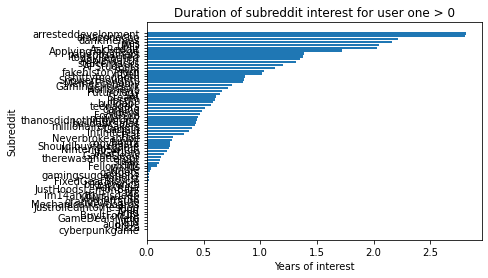

In [117]:
# sort and graph this
subreddits_interest_one_sorted = sorted(subreddits_interest_one.items(), key=lambda x: x[1])

keys = []
vals = []
for k, v in subreddits_interest_one_sorted:
    if v != 0:
        keys.append(k)
        vals.append(v / 3.154e+7)

plt.barh(keys, vals)
plt.title("Duration of subreddit interest for user one > 0")
plt.xlabel("Years of interest")
plt.ylabel("Subreddit")
plt.show()

## Now, we want to create a weighting system for this. Let's create weights as a proportion of subreddit interest duration relative to average interest duration. While this could be as a proportion relative to total account age, I see an issue with this. Consider a redditor with a short attention span. They may be just as interested in certain topics (for the point of this project) as someone with a longer attention span, but the duration of that interest may represent a smaller period of their total activity timne on reddit.

In [118]:
# First, we must calculate the average duration of user one's interest in subreddits (in seconds)
one_interest_average = 0

for k, v in subreddits_interest_one_sorted:
    one_interest_average += v

one_interest_average /= len(subreddits_interest_one_sorted)

print(one_interest_average)

9183896.860294119


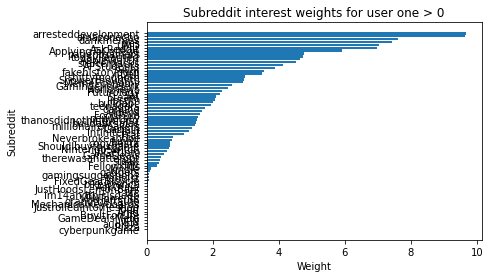

In [119]:
subreddits_interest_one_weights = defaultdict(lambda: 0)

for k, v in subreddits_interest_one_sorted:
    subreddits_interest_one_weights[k] = v / one_interest_average

keys = []
vals = []
for k in subreddits_interest_one_weights:
    v = subreddits_interest_one_weights[k]
    if v != 0:
        keys.append(k)
        vals.append(v)

plt.barh(keys, vals)
plt.title("Subreddit interest weights for user one > 0")
plt.xlabel("Weight")
plt.ylabel("Subreddit")
plt.show()

## repeat duration weight calculations for user 2

In [122]:
# comments/posts interest age
subreddits_interest_two = defaultdict(lambda: [current_time, 0])

# find oldest and most recent comments for each subreddit
for i, r in two_comment_df.iterrows():
    sub = str(r['subreddit'])

    if r['created_utc'] < subreddits_interest_two[sub][0]:
        subreddits_interest_two[sub][0] = r['created_utc']
    
    if r['created_utc'] > subreddits_interest_two[sub][1]:
        subreddits_interest_two[sub][1] = r['created_utc']

# find the oldest and most recent submissions for each subreddit, replacing the timestamp for the comments if older/more recent respectively
for i, r in two_post_df.iterrows():
    sub = str(r['subreddit'])

    if r['created_utc'] < subreddits_interest_two[sub][0]:
        subreddits_interest_two[sub][0] = r['created_utc']
    
    if r['created_utc'] > subreddits_interest_two[sub][1]:
        subreddits_interest_two[sub][1] = r['created_utc']

# calculate the difference in time in order to get interest length
for k in subreddits_interest_two:
    v = subreddits_interest_two[k]
    subreddits_interest_two[k] = v[1] - v[0]

# create the weighting system
two_interest_average = 0
for k in subreddits_interest_two:
    v = subreddits_interest_two[k]
    two_interest_average += v
two_interest_average /= len(subreddits_interest_two)


subreddits_interest_two_weights = defaultdict(lambda: 0)
for k in subreddits_interest_two:
    v = subreddits_interest_two[k]
    subreddits_interest_two_weights[k] = v / one_interest_average

print(subreddits_interest_two_weights)


defaultdict(<function <lambda> at 0x000002009E824550>, {'UMD': 0.1727087122305948, 'musictheory': 3.567897429430693, 'law': 0.00018075115882201204, 'linux': 33.34035885396409, 'haskell': 28.579281866150477, 'jazzguitar': 11.299854688990541, 'John_Frusciante': 0.0, 'science': 31.294524249567377, 'Virginia': 0.0, 'Guitar': 30.246303636200025, 'apexlegends': 0.6151649006889074, 'ProgrammingLanguages': 0.3386600532772527, 'iamverysmart': 7.600259569744844e-05, 'politics': 27.858439058276435, 'worldnews': 24.0736958791281, 'Republican': 4.6771820996500555, 'mildlyinteresting': 0.0, 'functionalprogramming': 0.0, 'C_Programming': 9.977741735773954, 'britishproblems': 0.07828256468213164, 'york': 0.0, 'Jazz': 0.0, 'math': 23.92648418668791, 'BabyBumps': 0.0, 'asoiaf': 0.0, 'yrc': 13.889597187387709, 'IAmA': 19.765008771471194, 'askscience': 17.045321651727114, 'classicalmusic': 0.0002514183287470035, 'compsci': 14.496609884155022, 'thebutton': 0.0, 'travel': 0.0, 'television': 0.00121103276410

In [ ]:
# weight comments and weight posts appropriately
COMMENT_CONSTANT = 1.0
SUBMISSION_CONSTANT = 9.0

# length weight, age weight, interest weight


In [ ]:
TODO:

-resources: praw docs, matplotlib docs
